**Table of contents**

* [Parts of Speech](#pos)
* [Hidden Markov Models](#hmm)
* [Maximum likelihood estimation for labelled data](#mle)
* [Implementation](#imp)
* [Evaluation](#eval)
    * [Perplexity](#ppl)
    * [Viterbi](#viterbi)    
    * [Accuracy](#acc)

    
**Table of Exercises**

* Theory (10 points)
    * [Exercise 4-4](#ex4-4)
    * [Exercise 4-5](#ex4-5)
    * [Exercise 4-6](#ex4-6)
    * [Exercise 4-7](#ex4-7)
    * [Exercise 4-8](#ex4-8)
    * [Exercise 4-9](#ex4-9)
* Practice (30 points)    
    * [Exercise 4-1](#ex4-1)
    * [Exercise 4-2](#ex4-2)
    * [Exercise 4-3](#ex4-3)
    * [Exercise 4-10](#ex4-10)
    * [Exercise 4-11](#ex4-11)
    * [Exercise 4-12](#ex4-12)



**General notes**

* In this notebook you are expected to use $\LaTeX$. 
* Use python3.
* Use NLTK to read annotated data.
* **Document your code**: TAs are more likely to understand the steps if you document them. If you don't, it's also difficult to give you partial points for exercises that are not completely correct.

# <a name="pos"> Parts of Speech
    
**Parts of speech** (also known as PoS, word classes) give us information about a word and its neighbors. 
PoS can can be divided into: closed class and open class.

Open class words (or **content words**) are nouns, verbs, adjectives, and adverbs, where they refer to objects, actions, and features in the world. They are called open class, since there is no limit to what these words are
new ones are added all the time (email, website, selfie, etc.).

**Nouns** suchs as proper nouns are names of persons of entitnes: *Regina*, *Colorado*,
and *IBM*. Other type are common nouns that refer to objects that for exmaple, can be counted (one car) or homogeneus groups (snow, sand).

**Verbs** consists pf actions and processes, like *draw*, *provide*, and *go*.

***Adjectives** include terms for properties or qualities for concepts like age (*old*, *young*), value (*good*, *bad*).



Closed class words (or **function words**) are pronouns, determiners, prepositions, and connectives. There is a limited number of these.


**Prepositions** occur before noun phrases and indicate spatial or temporal relations, for example, *by* the house.

The PoS are tags that classifiy words. For example in English uses the 36 tags. And these tags are used to manually annotate a wide variety of corpora, the Brown corpus, the Wall Street Journal corpus.

In this Lab we are going to work with the English [Penn Treebank](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) tag set and the annotated corpus.

Our final goal is the task: 
* **Part-of-speech tagging** (tagging for short) is the process of assigning a part-ofspeech tag to each word in an input text.

First, we will download the annotated data from [NLTK](https://www.nltk.org/data.html)

In [1]:
# Read annotated corpora with NLTK
# first download data
import nltk
#nltk.download()
# it will open a GUI and you have to double click in "all" to download 
# this will download different types of annotated corpora

In [2]:
import sys
sys.version


'3.5.2 (default, Nov 23 2017, 16:37:01) \n[GCC 5.4.0 20160609]'

With NLTK, we load the annotated **Penn Treebank** corpus.
This corpus will be used to train and test our PoS taggers. Let's use the last 100 sentences for test.

In [69]:
# inspect PoS from Treebank
# we use the universal tagset
treebank_sents = nltk.corpus.treebank.tagged_sents(tagset='universal')

# we split our corpus on training, dev and test
treebank_training = list(treebank_sents[:3000]) 
treebank_dev = list(treebank_sents[3000:3100])
treebank_test = list(treebank_sents[3100:])
print(len(treebank_sents))
print(len(treebank_training)) 
print(len(treebank_dev)) # we use 100 sentences/instances for validation
print(len(treebank_test)) # we use 814 sentences/instances for test

3914
3000
100
814


In [70]:
# which is the vocabulary?
# we can inspect the vocabulary of the corpus 
vocabulary = set([w for (w, t) in nltk.corpus.treebank.tagged_words(tagset='universal')])
print(len(vocabulary)) # number of words in our corpus
# we inspect the universal tagset (this is a general mapping becasue each languge use a different tagset.
tagset = set([t for (w, t) in nltk.corpus.treebank.tagged_words(tagset='universal')])

print(tagset) # tags/labes used to annotate the word class

12408
{'DET', 'ADP', 'CONJ', 'X', 'ADV', 'NOUN', 'ADJ', 'VERB', 'PRON', 'NUM', 'PRT', '.'}


In [5]:
# The observations are pairs: (sentence, tags)
# so we can use this to get just the sentences (when we need them)
def extract_sentences(treebank_corpus):
    sentences = []
    for observations in treebank_corpus:
        sentences.append([x for x, c in observations])
    return sentences

# The observations are pairs: (sentence, tags)
# so we can use this to get just the tags (when we need them)
def extract_tags(treebank_corpus):
    tags = []
    for observations in treebank_corpus:
        tags.append([c for x, c in observations])
    return tags

<a name="ex4-1" style="color:red">**Exercise 4-1**</a> **[2 points]** 

* **[1 point]** Load the PTB corpus and plot the distribution of POS tags. 
* **[1 point]** Do the same for the Brown corpus.  


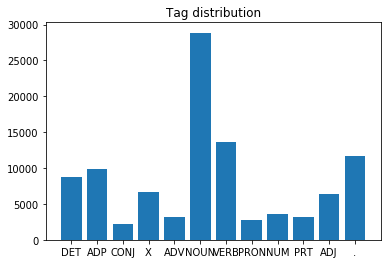

In [111]:
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter

def distribution(corpus):
    count = defaultdict(int)
    tag_list = list()
    for line in corpus:
        sets, tags = zip(*line)
        tag_list.extend(tags)
    count = Counter(tag_list)
        
    plt.bar(range(len(count)), count.values(), align="center")
    plt.xticks(range(len(count)), list(count.keys()))
    plt.title('Tag distribution')
    plt.show()


distribution(treebank_sents)

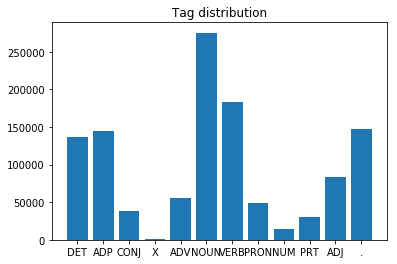

In [112]:
brown_sents = nltk.corpus.brown.tagged_sents(tagset='universal')
distribution(brown_sents)


<a name="ex4-2" style="color:red">**Exercise 4-2**</a> **[1 point]** Load the PTB corpus, find out for each POS tag what is the most likely tag that follows it. 

In [118]:
import operator

def followed_max(corpus):
    follow_count = defaultdict(int)
    for line in corpus:
        sent, tags = zip(*line)
        for i, tag in enumerate(tags):
            # Check if index is in bound else use EoS symbol
            if i < len(tags) - 1:
                next_tag = tags[i + 1]
            else: next_tag = '-EOS-'
            if tag not in follow_count:
                follow_count[tag] = defaultdict(int)
            follow_count[tag][next_tag] += 1

    follow_max = {}
    for tag, counts in follow_count.items():
        follow_max[tag] = max(counts.items(), key=operator.itemgetter(1))[0]

    return follow_max

print("PTB POS followed max by: ", followed_max(treebank_sents))
print("Brown POS followed max by: ", followed_max(brown_sents))

PTB POS followed max by:  {'DET': 'NOUN', 'ADP': 'DET', 'CONJ': 'NOUN', 'X': 'VERB', 'ADV': 'VERB', 'NOUN': 'NOUN', 'VERB': 'X', 'PRON': 'VERB', 'NUM': 'NOUN', 'PRT': 'VERB', 'ADJ': 'NOUN', '.': '-EOS-'}
Brown POS followed max by:  {'DET': 'NOUN', 'ADP': 'DET', 'CONJ': 'NOUN', 'X': 'X', 'ADV': 'VERB', 'NOUN': '.', 'VERB': 'VERB', 'PRON': 'VERB', 'NUM': 'NOUN', 'PRT': 'VERB', 'ADJ': 'NOUN', '.': '-EOS-'}


<a name="ex4-3" style="color:red">**Exercise 4-3**</a> **[1 point]** Find the most frequent verb on the PTB and on the Brown corpus.

In [114]:

def max_verb(corpus):
    count = defaultdict(int)
    for line in corpus:
        for w, t in line:
            if t == "VERB":
                count[w] += 1
    return max(count.items(), key=operator.itemgetter(1))
    
verb, c1 = max_verb(treebank_sents)
verb2, c2 = max_verb(brown_sents)
print("Most frequent verb in PTB is  :",verb, " \nWith count: ", c1)
print("Most frequent verb in Brown is:",verb2, " \nWith count: ", c2)

Most frequent verb in PTB is  : is  
With count:  671
Most frequent verb in Brown is: is  
With count:  10010


# <a name="hmm"> Hidden Markov Models

* How can we learn a PoS tagger given this dataset?

The Hidden Markov Model **HMM** is a sequence model. A sequence model or sequence classifier is a
model whose job is to assign a label or class to each unit in a sequence, thus mapping
a sequence of observations to a sequence of labels.

For example, in PoS the HMM will assing a tag to each word in a sentence: 

*Mr. Vinken is chairman of Elsevier N.V. the Dutch publishing group.*

The output of a tagger would look like one of the annotated sentences form the Treeban corpus:

In [11]:
print(treebank_training[1])

[('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]


Let's start by defining the **HMM**
    
We consider two phenomena:
* Transition: we move from one "state" to another "state" where our state is the POS tag
* Emission: with a certain "state" in mind, we generate a certain word

This means that in the sentence above, for example, we generate
1. From the state `BoS` (begin of sequence) we generate the state `NOUN`
2. Then from `NOUN` we generate the word `Mr.`
3. We then "forget" the word we just emitted and use the fact that our current state is `NOUN` to generate the next state, which is again a `NOUN`
4. From where we then generate `Vinken`
5. We proceed like that until we exaust both sequences


Let us give names to things, let's model the current class with a random variable $C$ and let's use the random variable $C_{\text{prev}}$ to model the previous category. For the word we will use the random variable $X$.
Both $C$ and $C_{\text{prev}}$ take on values in the enumeration of a tagset containing $t$ tags, that is, $\{1, \ldots, t\}$. $X$ takes on values in the enumeration of a vocabulary containing $v$ words, that is, $\{1, \ldots, v\}$.

The **transition** distribution captures how our beliefs in a class vary as a function of the previous class. We will use Categorical distributions for that. In fact, for each possible previous class we get a Categorical distribution over the complete set of classes.

\begin{align}
(1) \qquad C \mid C_{\text{prev}}=p \sim \text{Cat}(\lambda_1^{(p)}, \ldots, \lambda_t^{(p)})
\end{align}
    

<a name="ex4-4" style="color:red">**Exercise 4-4**</a> **[1 point]** What is the probability value of  $P_{C|C_{\text{prev}}}(c|p)$?

$\lambda_c^p$

<a name="ex4-5" style="color:red">**Exercise 4-5**</a> **[2 points]**

* **[1 point]** How many cpds do we need in order to represent all transition distributions?
* **[1 point]** What's the representation cost of such a set of distributions? Use [big-O notation](https://en.wikipedia.org/wiki/Big_O_notation).



For every tag we have a distribution of length t.
- $t$
- $O(t^2)$


The **emission** distribution captures how our beliefs in a word vary as a function of the word's class. We will again use Categorical distributions for that. In fact, for each possible class, we get a Categorical distribution over the complete vocabulary.


\begin{align}
(2) \qquad X \mid C=c \sim \text{Cat}(\theta_1^{(c)}, \ldots, \theta_v^{(c)})
\end{align}
   

<a name="ex4-6" style="color:red">**Exercise 4-6**</a> **[1 point]** What's the probability value of $P_{X|C}(x|c)$?

$\theta_x^c$


<a name="ex4-7" style="color:red">**Exercise 4-7**</a> **[2 points]** 

* **[1 point]** How many cpds do we need in order to represent all emission distributions? 
* **[1 point]** What's the representation cost of such a set of distributions? Use [big-O notation](https://en.wikipedia.org/wiki/Big_O_notation).



For every tag we have a distribution of length v.
- $t$ 
- $O(vt)$

Now let's turn to the joint distribution $P_{CX|C_{\text{prev}}}$ over classes and words and let's focus on a single step where we can assume the previous class is already available. Then the model factorises as follows:

\begin{align}
(3) \qquad P_{CX|C_{\text{prev}}}(x, c | c_{\text{prev}}) &= P_{C|C_{\text{prev}}}(c|c_{\text{prev}}) P_{X|C}(x|c) 
\end{align}

It will turn out useful to know what is the marginal distribution $P_{X|C_{\text{prev}}}$ over words given the previous class ---  where we have marginalised the current class out. 

\begin{align}
(4) \qquad P_{X|C_{\text{prev}}}(x| c_{\text{prev}}) &= \sum_{c=1}^t P_{CX|C_{\text{prev}}}(x, c | c_{\text{prev}}) \\
 &= \sum_{c=1}^t P_{C|C_{\text{prev}}}(c|c_{\text{prev}}) \times P_{X|C}(x|c) 
\end{align}

Note that Equation (4) starts by simply summing Equation (3) for all possible values of the current class, that is, for $c$ from 1 to $t$.



Our ultimate goal with the HMM is to assing a probability to a sentence $x_1^n$. For that we need to combine $n$ pairs $(c_i, x_i)$ and marginalise away their history $c_{i-1}$. Doing so yields the **joint probability**:

\begin{align}
(5) \qquad P_{X_1^nC_1^n|N}(x_1^n, c_1^n|n) &= P_{C|C_{\text{prev}}}(c_1|c_0)P_{X|C}(x_1|c_1)P_{C|C_{\text{prev}}}(c_2|c_1)P_{X|C}(x_2|c_1)\cdots P_{C|C_{\text{prev}}}(c_n|c_{n-1})P_{X|C}(x_n|c_n) \\
    &= \prod_{i=1}^n P(c_i|c_{i-1})P(x_i|c_i)
\end{align}


We can get the **marginal probability** of a sentence by summing over all possible values of all possible class variables. This requires summing for each and every $c_i$ from 1 to $t$ as follows:

\begin{align}
(6) \qquad P_{S|N}(x_1^n|n) &= \sum_{c_1=1}^t \cdots \sum_{c_n=1}^t P(c_1|c_0)P(x_1|c_1)P(c_2|c_1)P(x_2|c_1)\cdots P(c_n|c_{n-1})P(x_n|c_n) \\
&= \sum_{c_1=1}^t \cdots \sum_{c_n=1}^t  \prod_{i=1}^n P(c_i|c_{i-1})P(x_i|c_i)
\end{align}

This looks pretty bad! If we have to enumerate all possible tag sequences, there would be just too many of them. That is, in the first sum, $c_1$ takes 1 of $t$ values, then for each of those values $c_2$ will take 1 of $t$ values, and so on. This leads to $t^n$ different tag sequences. An exponential number of them!!! We will never manage to enumerate them, compute their joint probabilities and then sum them up. 

Luckily, it turns out that in the HMM only two variables interact at a time, that is, $c_i$ interacts with $c_{i-1}$, then $c_i$ interacts with $x_i$, thus to characterise the distribution over $x_i$ we only need to know $c_{i-1}$ and $c_i$ --- which Equation (4) also shows. We can simplify Equation (6) by rearranging the sums and products as in Equation (7) below.

\begin{align}
(7) \qquad P_{S|N}(x_1^n|n) &= \sum_{c_1=1}^t \cdots \sum_{c_n=1}^t  \prod_{i=1}^n P(c_i|c_{i-1})P(x_i|c_i) \\
&= \prod_{i=1}^n \sum_{c_{i-1}=1}^t \sum_{c_i=1}^t P(c_i|c_{i-1})P(x_i|c_i)
\end{align}

This is great news because it reveals that to marginalise the tag sequences we only need to scan over the sentence $i=1, \ldots, n$ and then scan over the possible combinations of two tags from the tagset. 


<a name="ex4-8" style="color:red">**Exercise 4-8**</a> **[3 points]** What is the algorithmic complexity of computing the marginal probability of a sentence in the HMM model?  

$O(nt^2)$
where $n$ is the number of words in the sentence and $t$ is the number of tags in the corpus


Equation (5) gives us a simple algorithm to assign joint probabilities to sequences of the kind $(c_1^n, x_1^n)$. 
Because we chose categorical distributions as in Equations (1) and (2), we can say that 

\begin{align}
P_{CX|C_{\text{prev}}}(x, c | p) = \lambda_{c}^{(p)} \times \theta_{x}^{(p)}
\end{align}

and therefore Equation (5) is simply

\begin{align}
(8) \qquad P_{X_1^nC_1^n|N}(x_1^n, c_1^n|n) &= \prod_{i=1}^n P(c_i|c_{i-1})P(x_i|c_i) \\
 &= \prod_{i=1}^n  \lambda_{c_i}^{(c_{i-1})} \times \theta_{x_i}^{(c_i)}
\end{align}

Similarly, Equation (7) is great because it gives us an algorithm to assign probabilities to sentences. 
If we now use our parameters to rewrite Equation (7)  we get 

\begin{align}
(9) \qquad P_{S|N}(x_1^n|n) &= \prod_{i=1}^n \sum_{c_{i-1}=1}^t \sum_{c_i=1}^t P(c_i|c_{i-1})P(x_i|c_i) \\
&= \prod_{i=1}^n \sum_{c_{i-1}=1}^t \sum_{c_i=1}^t  \lambda_{c_i}^{(c_{i-1})} \times \theta_{x_i}^{(c_i)}
\end{align}



# <a name="mle"> Maximum likelihood estimation for labelled data
    
As we know by now, MLE for Categorical CPDs is just a matter of counting and dividing.

The MLE solution for the transition distribution is therefore

\begin{align}
(10) \qquad \lambda_c^{(p)} = \frac{\text{count(p, c)}}{\text{count}(p)}
\end{align}

<a name="ex4-9" style="color:red">**Exercise 4-9**</a> **[1 points]** What is the MLE solution for the emission distribution? Note: use the same style as in Equation (10), that is, state the parameter and the solution. 

\begin{align}
(10) \qquad \theta_v^{(c)} = \frac{\text{count(c, v)}}{\text{count}(c)}
\end{align}

Now you will **implement** the HMM, this means you will implement *transition distributions*, *emission distributions*, *Laplace smoothing*, *joint probability*, *marginal probability*, and an algorithm for making *predictions*.

# <a name="imp"> Implementation

Here you will implement a language model based on an HMM POS tagger. 

<a name="ex4-10" style="color:red">**Exercise 4-10**</a> **[17 points]** 

You will need to complete the skeleton class below. Read it through before coding. Check the documentation for additional information. Document your steps (this will increase your chance of earning points in case you make mistakes along the way). 

* **[8 points]** Implement `estimate_model`: this should take an annotated corpus (such as PTB or Brown) and estimate the CPDs in the model using Laplace smoothing. 
* **[2 points]** Implement `transition_parameter`: see method's documentation
* **[2 points]** Implement `emission_parameter`: see method's documentation
* **[1 points]** Implement `joint_parameter`: see method's documentation
* **[2 points]** Implement `log_joint`: see method's documentation
* **[2 points]** Implement `log_marginal`: see method's documentation

Show that you methods work by training a model and testing a few examples. This is an example 

```python
treebank_hmm = HMMLM()
treebank_hmm.estimate_model(treebank_training)
print(treebank_hmm.joint_parameter('DET', 'NOUN', 'book'))
sentence = [x for x, _ in treebank_dev[0]]
tag_sequence = [c for _, c in treebank_dev[0]]
print(' '.join(sentence))
print(' '.join(tag_sequence))
print(treebank_hmm.log_joint(sentence, tag_sequence))
```

for which we get

```
9.959527643028553e-05
At Tokyo , the Nikkei index of 225 selected issues , which *T*-1 gained 132 points Tuesday , added 14.99 points to 35564.43 .
ADP NOUN . DET NOUN NOUN ADP NUM VERB NOUN . DET X VERB NUM NOUN NOUN . VERB NUM NOUN PRT NUM .
-193.71018537
```


In [28]:
import numpy as np
from collections import defaultdict

class HMMLM:
    """
    This is our HMM language model class.
    
    It will be responsible for estimating parameters by MLE
    as well as computing probabilities using the HMM.
    
    We will use Laplace smoothing by default (because we do not want to assign 0 probabilities).
    
    GUIDELINES:
        - by convention we will use the string '-UNK-' for an unknown POS tag
            - and '<unk>' for an unknown word
        - don't forget that with Laplace smoothing the unknown symbols have to be in the support of distributions
        - now you will have 2 types of distributions, so you should deal with unknown symbols for both of them
        - we also need padding for sentences and tag sequences, by convention we will use 
            - '-BOS-' and '-EOS-' for padding tag sequences
            - '<s>' and '</s>' for padding sentences
        - do recall that '-BOS-' is **not** a valid tag
            in other words we never *generate* '-BOS-' tags, we only pretend they occur at
            the 0th position of the tag sequence in order to provide conditioning context
            for the first actual tag
        - similarly, '<s>' is not a valid word
            in other words, we never *generate* '<s>' as a word
            in fact '<s>' is optional as no emission event is based on it
        - on the other hand, '-EOS-' is a valid tag
            you should model it as the last event of a tag sequence
        - similarly, '</s>' is a valid word
            you should consider it as the last event of a sentence
            
    You can use whatever data structures you like for cpds
        - we suggest python dict or collections.defaultdict
            but you are free to experiment with list and/or np.array if you like
    """
    
    def __init__(self, transition_alpha=1.0, emission_alpha=1.0):
        self._vocab = set()
        self._tagset = set()
        self._emission_cpds = dict()
        self._transition_cpds = dict()
        self._transition_alpha = transition_alpha
        self._emission_alpha = emission_alpha
        
    def tagset(self):
        """
        Return the tagset: a set of all tags seen by the model (including '-UNK-').
        
        You can modify this if you judge necessary (for example, because you decided  to 
            use different datastructures, but do note that we provide you an implementation
            of the Viterbi algorithm that expects this functionality).        
        """        
        # the -BOS- tag is just something for internal representation
        #  in case you have added it to the tagset, we are removing it here
        #  as keeping it would be bad for algorithms such as Viterbi
        # the -UNK- tag must be in the support (due to Laplace smoothing)
        #  thus in case you forgot it, we are adding it now
        return self._tagset - {'-BOS-'} | {'-UNK-'}
    
    def addTag(self, tag):
        """
        Adds a tag to the tagset variable
        """
        self._tagset.add(tag)
    
    def vocab(self):
        """
        Return the vocabulary of words: all words seen by the model (including '<unk>').
        
        You can modify this if you judge necessary (for example, because you decided  to 
            use different datastructures, but do note that we provide you an implementation
            of the Viterbi algorithm that expects this functionality).        
        """        
        # the <s> token is just something for internal representation
        #  in case you have added it to the vocabulary, we are removing it here
        # the <unk> word must be in the support (due to Laplace smoothing)
        #  thus in case you forgot it, we are adding it now
        return self._vocab - {'<s>'} | {'<unk>'}
    
    def addWord(self, word):
        """
        Adds a word to the vocab variable
        """
        
        self._vocab.add(word)
        
    def preprocess_sentence(self, sentence, bos=True, eos=True):
        """
        Preprocess a sentence by lowercasing its words and possibly padding it.
        
        :param sentence: a list of tokens (each a string)
        :param bos: if True you will get <s> at the beginning 
        :param eos: if True you will get </s> at the end
        :returns: a list of tokens (lowercased strings)
        """
        # lowercase
        sentence = [x.lower() for x in sentence]
        # optional padding
        if bos: 
            sentence = ['<s>'] + sentence
        if eos:
            sentence = sentence + ['</s>']
        return sentence
        
    def preprocess_tag_sequence(self, tag_sequence, bos=True, eos=True):
        """
        Preprocess a tag sequence with optional padding.
        
        :param tag_sequence: a list of tags (each a string)
        :param bos: if True you will get -BOS- at the beginning 
        :param eos: if True you will get -EOS- at the end
        :returns: a list of tokens 
        """
        # optional padding
        if bos:
            tag_sequence = ['-BOS-'] + tag_sequence
        if eos:
            tag_sequence = tag_sequence + ['-EOS-']
        return tag_sequence
        
    def estimate_model(self, treebank):
        """
        :param treebank: a sequence of observations as provided by nltk
            each observation is a list of pairs (x_i, c_i)    
            and they have not yet been pre-processed 
        
        Estimate the model parameters.
        
        This method does not have to return anything, it simply computes the necessary cpds.        
        """
        
        # Create count table for emission and transition(defaultdict(int))
        emis_count_table = {'-UNK-' : {'<unk>': 0}}
        tran_count_table = {'-UNK-' : {'-UNK-': 0}}
             
        print("Start counting")
        for i, tag_sent in enumerate(treebank):
            # Preprocess the sentence and tag_sequence
            sentence, tags = map(list, zip(*tag_sent))
            sentence = self.preprocess_sentence(sentence)
            tags = self.preprocess_tag_sequence(tags)
            
            # Fill count tables
            for i, word in enumerate(sentence[1:], 1):
                tag = tags[i]
                tag_prev = tags[i-1]
                
                # Add word to tag emission_count: P(word|tag)
                if tag not in emis_count_table:
                    emis_count_table[tag] = defaultdict(int)
                emis_count_table[tag][word] += 1
                if '<unk>' not in emis_count_table[tag]:
                    emis_count_table[tag]['<unk>'] = 0
                
                # Add tag to prevtag in transition_count: P(tag|tag_prev)
                if tag_prev not in tran_count_table:
                    tran_count_table[tag_prev] = defaultdict(int)
                tran_count_table[tag_prev][tag] += 1
                if '-UNK-' not in tran_count_table[tag_prev]:
                    tran_count_table[tag_prev]['-UNK-'] = 0
                
                # Add tag and word to tagset andd vocab
                self.addTag(tag)
                self.addWord(word)
        
        print("Start calculating cpd's")
        # Parse count tables and convert them to CPD's
        for i, (tag, word_count) in enumerate(emis_count_table.items()):
            print('.', end='')
            self._emission_cpds[tag] = defaultdict(float)
            total_count = sum(word_count.values())
            for word, count in word_count.items():
                prob = (float(count) + self._emission_alpha) / \
                       (total_count + self._emission_alpha * len(self.vocab()))
                self._emission_cpds[tag][word] = prob

        for tag_prev, tag_count in tran_count_table.items():
            self._transition_cpds[tag_prev] = defaultdict(float)
            total_count = sum(tag_count.values())
            
            for tag, count in tag_count.items():
                prob = (float(count) + self._transition_alpha) / \
                       (total_count + self._transition_alpha * len(self.tagset()))
                self._transition_cpds[tag_prev][tag] = prob
                
        print("\nFinished cpd's")
    
    def transition_parameter(self, previous_tag, current_tag):
        """
        This method returns the transition probability for tag given the previous tag.
        
        Tips: do not forget that we have a smoothed model, thus 
            - if the either tag was never seen, you should pretend it to be '-UNK-'
        
        :param previous_tag: the previous tag (str)
        :param current_tag: the current tag (str)
        :return: transition parameter
        """
        if previous_tag not in self._transition_cpds:
            previous_tag = '-UNK-'
        if current_tag not in self._transition_cpds[previous_tag]:
            current_tag = '-UNK-'
        return self._transition_cpds[previous_tag][current_tag]        
    
    def emission_parameter(self, tag, word):
        """
        This method returns the emission probability for a word given a tag.
        Tips: do not forget that we have a smoothed model, thus 
            - if the tag was never seen, you should pretend it to be '-UNK-'
            - similarly, if the word was never seen, you shoud pretend it to be '<unk>'
        
        :param tag: the current tag (str)
        :param word: the current word (str)
        :return: the emission probability
        """
        if tag not in self._emission_cpds:
            tag = '-UNK-'
        if word not in self._emission_cpds[tag]:
            word = '<unk>'
        return self._emission_cpds[tag][word]
        
    def joint_parameter(self, previous_tag, current_tag, word):
        """
        This method returns the joint probability of (current tag, word) given the previous tag
            according to Equation (3)
            
        :param previous_tag: the previous tag (str)
        :param current_tag: the current tag (str)
        :param word: the current word (str)
        :returns: P(word, current_tag|previous_tag)
        """
        pcp = self.transition_parameter(previous_tag, current_tag)
        pxc = self.emission_parameter(current_tag, word)
        return pcp * pxc
    
    def marginal_x_given_cprev(self, previous_tag, word):
        """
        Return P(x|prev) as defined in Equation (4) by marginalising current tag.
        
        :param previous_tag: the previous tag (str)
        :param word: the current word (str)
        """
        return np.sum([self.joint_parameter(previous_tag, c, word) for c in self._tagset])
    
    def log_joint(self, sentence, tag_sequence):
        """
        Implement the logarithm of the joint probability over a sentence and tag sequence as in Equation (8)
        
        :param sentence: a sequence of words (each a string) not yet preprocessed
        :param tag_sequence: a sequence of tags (eac a string) not yet preprocessed
        :returns: log P(x_1^n, c_1^n|n) as defined in Equation (8)
        """ 
        sentence = self.preprocess_sentence(sentence)
        tag_sequence = self.preprocess_tag_sequence(tag_sequence)
        
        joint_prob = 0
        for i, word in enumerate(sentence[1:], 1):
            tag = tag_sequence[i]
            prev_tag = tag_sequence[i - 1]
            joint_prob += np.log(self.joint_parameter(prev_tag, tag, word))
        return joint_prob
    
    def log_marginal(self, sentence):
        """
        Implement the logarithm of the marginal probability of a sentence as in Equation (9)
            by marginalisation of all possible tag sequences. 
            
        :param sentence: a sequence of words (each a string) not yet preprocessed
        :returns: log P(x_1^m|n) as defined in Equation (9)
        """
        sentence = self.preprocess_sentence(sentence)
        
        return sum([np.log(sum([self.marginal_x_given_cprev(p,w) for p in self.tagset()])) for w in sentence])

In [66]:
treebank_hmm = HMMLM()
treebank_hmm.estimate_model(treebank_training)

print(treebank_hmm.joint_parameter('DET', 'NOUN', 'book'))
sentence, tag_sequence = map(list, zip(*treebank_dev[0]))
print(' '.join(sentence))
print(' '.join(tag_sequence))
print(treebank_hmm.log_joint(sentence, tag_sequence))
print(treebank_hmm.log_marginal(sentence))


Start counting
Start calculating cpd's
..............
Finished emission cpd's
..............
Finished transition cpd's
9.959527643028553e-05
At Tokyo , the Nikkei index of 225 selected issues , which *T*-1 gained 132 points Tuesday , added 14.99 points to 35564.43 .
ADP NOUN . DET NOUN NOUN ADP NUM VERB NOUN . DET X VERB NUM NOUN NOUN . VERB NUM NOUN PRT NUM .
-193.71018536983053
-123.19211447683843


In [159]:
print(treebank_hmm.joint_parameter('DET', 'VERB', 'cat'))


7.062115274614483e-06


# <a name="eval"> Evaluation
    
We can evaluate our models by the computing the log-perplexity, like with the LM or by comparing the predictions of the trained model with an annotated test set.


## <a name="ppl"> Perplexity

Perplexity of a model on a test set is the inverse probability of the test set, normalized
by the number of words. Perplexity is a notion of average branching factor, thus a model with low perplexity can be thought of as a *less confused*. That is, each time it introduces a word given some history it picks from a reduced subset of the entire vocabulary (in other words, it is more certain of how to continue). 

If a dataset contains $t$ tokens where $t = \sum_{k=1}^m n_k$, then the perplexity of the dataset is

\begin{equation}
(11) \qquad \text{PP}(\mathcal T) = \left( \prod_{k=1}^m P_{S|N}(\langle x_1^{(k)}, \ldots, x_{n_k}^{(k)} \rangle|n_k; \boldsymbol \theta) \right)^{-1/t}
\end{equation}

where we have already discarded the length distribution (since it's held constant across models). And the probability of the sentence requires marginalising tag sequences, as shown in Equation (9).

It's again convenient to use log and define log-perplexity

\begin{equation}
(12) \qquad \log \text{PP}(\mathcal T) = - \frac{1}{t} \sum_{k=1}^m \log P_{S|N}(\langle x_1^{(k)}, \ldots, x_{n_k}^{(k)} \rangle|n_k; \boldsymbol \theta) 
\end{equation}

You can compare models in terms of the log-perplexity they assign to the same test data. The lower the perplexity, the better the model is.

<a name="ex4-11" style="color:red">**Exercise 4-11**</a> **[4 points]** Implement `log_perplexity` below. Train models of PTB and Brown and test both of them on their respective test sets as well as on each other's test set. Report all results.

To help you have an idea whether you implemented it right, this is an excerpt of what we got with our implementation

```python
dev_sentences = extract_sentences(treebank_dev)
log_perplexity(dev_sentences, treebank_hmm)
```

```
101.80708039918399
```

By the way, this is how you load the Brown corpus. Let's use the last 1000 sentences for test. You can reduce the size of the training set if your computer cannot handle what we suggest below.

In [22]:
# load the Brown corpus wiht the universal tag set
brown_sentences = nltk.corpus.brown.tagged_sents(tagset='universal')

# we split our corpus on training, dev and test
brown_training = list(brown_sentences[:56000]) 
brown_dev = list(brown_sentences[56000:56340])
brown_test = list(brown_sentences[56340:])
print(len(brown_sentences), len(brown_training), len(brown_dev), len(brown_test))

57340 56000 340 1000


In [49]:
def log_perplexity(sentences, hmm):
    """
    For a dataset of sentences (each sentence is a list of words)
        and an instance of the HMMLM class
        return the log perplexity as defined in Equation (12)
    """
    
    t = sum([len(s) + 2 for s in sentences])
    return -1.0 / t * sum([hmm.log_marginal(s) for s in sentences])

In [51]:
dev_sentences = extract_sentences(treebank_dev)
print(log_perplexity(dev_sentences, treebank_hmm))

brown_hmm = HMMLM()
brown_hmm.estimate_model(brown_training)

brown_dev_sentences = extract_sentences(brown_dev)
print(log_perplexity(brown_dev_sentences, brown_hmm))

4.689496628253122
Start counting
Start calculating cpd's
..............
Finished emission cpd's
..............
Finished transition cpd's
4.668776756438641


## <a name="viterbi"> Viterbi


The Viterbi algorithm is used to search through the space of possible tag sequences and find the one that score highest.

The space of tag sequences is very large, consider that we can select any of $t$ tags for each position, thus by simple counting, we are left with $t^n$ possible sequences. Searching through an exponential space is intractable in general. 

Not by chance we designed the HMM with certain conditional independence assumptions. In fact, in our HMM model the probability of each word observation really only depends on two decisions, namely, its tag and its preceding tag. We can use that to derive a *tractable* dynamic program. 

[Dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming) is a kind of *divide and conquer* strategy. We have to identify sub-problems that we can solve efficiently and maintain a memory of partial solutions that we use to build the final one.

For the Viterbi algorithm we need to solve the problem "what is the best probability so far". We will approach this problem with a recursion that computes the probability of the best path of a certain length.
We will use the recursive function $\alpha(i, j)$ which returns the best probability for a path of length $i$ assuming that its last tag is $C_i=j$. For efficiency in our implementation we will map tags to integers.

The Viterbi recursion is pretty simple, if a path has length $0$ we will assume it has probability $1$. If a path has length $i$ (more than $0$), we reckon that its maximum probability is based on the maximum probability assigned to paths of size $i-1$, where we extend those paths with one steps and check which step yields the best probability.

The Viterbi recursion is formalised below:

\begin{align}
(13)\qquad \alpha(i, j) &= 
\begin{cases}
1 & \text{if }i = 0 \\
\max_{p \in \{1, \ldots, t\}} \alpha(i-1, p) \times \lambda_{j}^{p} \times \theta_{x_i}^{j} & \text{otherwise}
\end{cases}
\end{align}

Note that in the second line, we look for paths of size $i-1$ (which my have ended in one of $t$ possible previous tags) and we try to extend them with tag $j$. The probability of each hypothetical extension is the probability of the path we mean to extend $\alpha(i-1, p)$ times the joint parameters associated with the extension. That is, continuing from previous class $C_{i-1}=p$ with current class $C_i=j$ (that is a transition parameter), and generating the current word $X_i=x_i$ from the current class $C_i=j$ ( that is an emission parameter).

Note that the recursive function takes 2 inputs, $i$ which ranges from 1 to $n$, and $j$ which ranges from 1 to $t$. Thus we need to make at most $nt$ calls to this function. But also note that each time we call it, we have to solve (in the second line) a maximisation over $t$ possible assignments of the previous tag. Therefore the overall complexity of the algorithm is $O(nt^2)$. That's quite an improvement from $O(t^n)$, isn't it?

Of course, crucial to the success of the algorithm is that we use [memoization](https://en.wikipedia.org/wiki/Memoization), a technique by which we store partial solutions and never recompute things.

We provide you with a **recursive** implementation of the Viterbi algorithm which uses the interface of the HMMLM class that you designed above. You can use this implementation if you want to experiment with PTB and Brown corpus in the exercises below. Read the implementation carefully to learn from it. We have provided extensive documentation.
One important note is that we compute everything in log space, that's to rely on better numerical properties of log probabilities.

The Viterbi recursion gives us a way to compute the *probability* of the best path. To find the actual best path we just need to traverse the table of $\alpha(i, j)$ values looking for the decision (tag) that is best at each point.


In [34]:
def viterbi_recursion(sentence, hmm):
    """
    Computes the best possible tag sequence for a given input
    and also returns it log probability.
    
    This implementation uses recursion.
    
    :returns: tag sequence, log probability
    """
    # here we pad the sentence with </s> only
    sentence = hmm.preprocess_sentence(sentence, bos=False, eos=True)
    # this is the length (but recall that padding added 1 token) 
    n = len(sentence)
    # this is the complete tagset, which for convenience we will turn into a list
    tagset = list(hmm.tagset())
    t = len(tagset)
    # We need a table to store log alpha(i, j) values
    # - where i is an integer from 0 to n-1 which refers to a position in the list `sentence`
    #   i.e. sentence[i]
    # - and j is an integer from 0 to t-1 that refers to a tag in the list `tagset` 
    #   i.e. tagset[j] 
    # - together (i, j) means that we are setting `C_i = tagset[j]`    
    # - we will be exploring the space of possible tags per position
    #   thus our table has as many as n * t cells
    # - Recall that the value \log \alpha(i, j)
    #   corresponds to the log probability value of the best
    #   path (C_1, ..., C_i) such that C_i = j
    #   in other words the log probability of the best sequence up to the ith token where C_i = j
    # At the beginning path probabilities have not been computed, we use a probability of 0 to indicate that
    #  as we will be computing log probabilities, we use -inf instead
    #  numpy arrays are very handy and we can actually use the quantity -inf
    log_alpha_table = np.full([n, t], -float('inf'))
    # In a best path algorithm we are interested in two things
    #  the best score (or best log probability)
    #  as well as the path that corresponds to the best score
    # We compute the best score by moving i forward from 0 to n-1 computing the maximum value 
    #  and we traverse the table backwards following the path that led to the maximum
    #  thus we create a table of "back pointers"
    #  this is an integer for each cell (i, j) that tells us which tag `p` for position `i - 1`
    #   leads to the score stored in `log_alpha_table[i, j]`
    back_pointer_table = np.full([n, t], -1, dtype=int)

    # Here we define the log alpha recursion
    def log_alpha(i, j):
        """
        This function returns
                max_{c_1, ..., c_i=j} log P(c_1, ..., c_i=j) 
            where i is a (0-based) position in `sentence`
            and j is a (0-based) position in `tagset`
        """
        if i == 0:  # we do not need to tag the 0th position and it should not affect the probability
            return 0.  # np.log(1)
        # When we implement dynamic programs, we like to re-use computations already made
        # thus first of all we test if we have already computed a value for this cell
        # if so, it will not have a zero probability (-inf in log space)
        if log_alpha_table[i, j] != -float('inf'):  
            # then we can simply return it
            return log_alpha_table[i, j]
        # At this point we know we have not yet computed a score for this path
        #  thus we proceed to compute it
        # We will have to figure out the log prob of the best prefix
        #  and which tag best continues from it
        # There are exactly t classes that may tag this position
        #  thus we just go over the tagset trying one at a time
        #  and memorise the score we would have if we would select them
        path_max_log_prob = np.full(t, -float('inf'))
        for p in range(t):
            # this is the essential part of the recursion
            # we ask for the best score associated with the previous position 
            #  had it been tagged with p
            #  and we incorporate the probability of C_i = tagset[j] given that C_{i-1} = tagset[p]
            #   as well as the probability of X_i = sentence[i] given that C_i = tagset[j]
            path_max_log_prob[p] = log_alpha(i - 1, p) + np.log(hmm.joint_parameter(tagset[p], tagset[j], sentence[i]))
        # From all possibilities, we are only interested in the best
        log_alpha_table[i, j] = np.max(path_max_log_prob)
        # and we also want to store a pointer to the best
        back_pointer_table[i, j] = np.argmax(path_max_log_prob)
        return log_alpha_table[i, j]
    
    # Let's get the index associated with -EOS-
    #  which is the tag for the </s> symbol in sentence[-1]
    eos_index = tagset.index('-EOS-')
    # We want the last word in the sentence (</s>) to have the tag -EOS-
    #  thus we ask "what's the probability of the best path that ends in -EOS-?"
    max_log_prob = log_alpha(n - 1, eos_index)
    
    # Here we retrieve the backpointers for the best analysis
    #  the best analisys has n tags
    bwd_argmax = [None] * n
    #  the last tag is the -EOS- symbol
    bwd_argmax[-1] = eos_index
    # Here we maintain the "current tag" c_i
    c_i = eos_index
    for i in range(n - 1, 0, -1):  # we go backwards from c_{n-1} to c_1
        # and set the value of c_{i-1} for the current c_i
        bwd_argmax[i - 1] = back_pointer_table[i, c_i]
        # we need, of course, to update c_i
        c_i = bwd_argmax[i - 1]
    
    # Here we translate from ids back to actual tags (strings)
    #  we leave the -EOS- symbol out, since it was just a convenience 
    #  and return both the tag sequence and the total log probability
    return [tagset[c] for c in bwd_argmax[:-1]], max_log_prob

In [35]:
# let's tag a sentence
viterbi_path, viterbi_log_prob = viterbi_recursion(['i', 'wish', 'i', 'had', 'a', 'book', '.'], treebank_hmm)
print(viterbi_path, viterbi_log_prob)

['PRON', 'VERB', 'PRON', 'VERB', 'DET', 'NOUN', '.'] -42.817371568242855


##  <a name="acc"> Accuracy

We can evaluate the performance of our tagger by comparing its Viterbi predictions to human annotation. 

For this, we will use the gold standard test data (e.g. treebank_test). Evaluation metrics compute a score for a given model (e.g. our HMM tagger) by comparing the predicted labels that the model generated with the test data againts the gold standard annotation.

The **Accuracy** metric computes the percentage of instances in the test data that our tagger labeled correctly.
If we have a dataset of $m$ labelled sequences
\begin{equation}
\left( \langle x_1^{(k)}, \ldots, x_{n_k}^{(k)}\rangle, \langle \star_1^{(k)}, \ldots, \star_{n_k}^{(k)}\rangle \right)_{k=1}^m
\end{equation}
we can produce all Viterbi predictions
\begin{equation}
\left( \langle x_1^{(k)}, \ldots, x_{n_k}^{(k)}\rangle, \langle c_1^{(k)}, \ldots, c_{n_k}^{(k)}\rangle \right)_{k=1}^m
\end{equation}

and compute

\begin{align}
(14)\qquad \text{accuracy} &= \frac{\sum_{k=1}^m \sum_{i=1}^{n_k} [c_i^{(k)} = \star_i^{(k)}]}{\sum_{k=1}^m n_k}\\
&= \frac{\text{number of correct predictions}}{\text{total tokens}} 
\end{align}



<a name="ex4-12" style="color:red">**Exercise 4-12**</a> **[5 points]** 

* **[1 point]** Implement the accuracy function.
* **[1 point]** Compute accuracy on PTB's test set using a PTB-trained model
* **[1 point]** Compute accuracy on PTB's test set using a Brown-trained model
* **[1 point]** Compute accuracy on Brown's test set using a PTB-trained model
* **[1 point]** Compute accuracy on Brown's test set using a Brown-trained model

For this exercise you can use the Viterbi implementation we provided (or your own -- its up to you). With our own implementation we got $0.8446$ accuracy for PTB-training and PTB-test, and $0.8960$ for Brown-training and Brown-test.

In [ ]:
def accuracy(gold_sequences, pred_sequences):
    """
    Return percentage of instances in the test data that our tagger labeled correctly.
    
    :param gold_sequences: a list of tag sequences that can be assumed to be correct
    :param pred_sequences: a list of tag sequences predicted by Viterbi    
    """
    count_correct, count_total = 0, 0
    for i, combined in enumerate(zip(pred_sequences, gold_sequences)):
        for p, g in list(zip(*combined)):
            if p == g:
                count_correct += 1
            count_total += 1
    if count_total:
        return count_correct / count_total
    return None

def predict_corpus(test_set, hmm):
    """
    Returns viterbi predictions for all sentences in a given corpus
    
    :param test_set: A corpus of tagged sentences
    :param hmm     : A language model
    """
    gold_sequences, pred_sequences = list(), list()
    print('Making predictions', end='')
    for i, sequence in enumerate(test_set):
        if i % round(len(test_set) / 10) == 0:
            print('.', end='')
        sentence , tags = map(list, zip(*sequence))
        viterbi_tags, _ = viterbi_recursion(sentence, hmm)
        gold_sequences.append(tags)
        pred_sequences.append(viterbi_tags)
    return gold_sequences, pred_sequences
    

print("PTB -> PTB accuracy: ",round(accuracy(*predict_corpus(treebank_test, treebank_hmm)),4))
print("PTB -> Brown accuracy: ",round(accuracy(*predict_corpus(treebank_test, brown_hmm)),4))
print("Brown -> PTB accuracy: ",round(accuracy(*predict_corpus(brown_test, treebank_hmm)),4))
print("Brown -> Brown accuracy: ",round(accuracy(*predict_corpus(brown_test, brown_hmm)),4))
    
